In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def crop_to_template(img, x, y, w, h):
    return img[y:y+h, x:x+w]

In [3]:
def construct_warp_matrix_affine(p):
    M = np.array([[1,0,0],[0,1,0]], dtype=np.float64) # identity transformation
    M = M + p.reshape(2, 3, order='F')                # order='F' (Fortran - column first) is to match subscripts in paper and slides 
    return M

In [4]:
def get_gradients(img): 
    pad = 1
    grad_x_kernel = np.array([-1, 0, 1], dtype=np.float64)
    grad_y_kernel = np.array([[-1], [0], [1]], dtype=np.float64)
    padded_img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REPLICATE) # to obtain output of the same shape as input
    dI_dx = cv2.filter2D(padded_img, ddepth=-1, kernel=grad_x_kernel)              # ddepth = -1 means same number of color channels as input img
    dI_dy = cv2.filter2D(padded_img, ddepth=-1, kernel=grad_y_kernel)
    return dI_dx, dI_dy

In [5]:
def steepest_descent_affine(dI_dx, dI_dy):
    x, y = np.mgrid[0:dI_dx.shape[0], 0:dI_dx.shape[1]]
    sd = np.stack([x*dI_dx, x*dI_dy, y*dI_dx, y*dI_dy, dI_dx, dI_dy], axis=-1) # axis=-1 means stack along newly created dimension at the end
    return sd

In [6]:
def hessian_affine(sd):
    sd_outer_product = np.einsum('...j,...k->...jk', sd, sd) 
    H = sd_outer_product.sum(axis=(0,1))                     # sum over spatial dimensions
    return H

In [7]:
def steepest_descent_parameter_updates(sd, I, T):
    error_image = T - I
    sd_dp = (sd * error_image[..., np.newaxis]).sum(axis=(0,1))  # sum over spatial dimensions
    return sd_dp

In [8]:
def parameter_update(H, sd_dp):
    dp = np.linalg.pinv(H) @ sd_dp
    return dp

In [9]:
def lucas_kanade_matching(img_path, template_img_path, bbox, epsilon, p=None):
    if p is None:
        p = np.zeros(6, dtype=np.float64)
        
    p[4] = -bbox[0]
    p[5] = -bbox[1]
    
    M = construct_warp_matrix_affine(p)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    dimg_dx, dimg_dy = get_gradients(img)
    img = img.astype(np.float64)
    dimg_dx = dimg_dx.astype(np.float64)
    dimg_dy = dimg_dy.astype(np.float64)

    template_origin_img = cv2.imread(template_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    template_img = crop_to_template(template_origin_img, *bbox)
    template_img = template_img.astype(np.float64)

    warp_to_template_size = template_img.shape[:2][::-1]
    
    dp = np.inf
    while np.linalg.norm(dp) > epsilon:
        I = cv2.warpAffine(img, M, warp_to_template_size)
        dI_dx = cv2.warpAffine(dimg_dx, M, warp_to_template_size)
        dI_dy = cv2.warpAffine(dimg_dy, M, warp_to_template_size)
        
        plt.imshow(I, cmap='gray')
        plt.show()
        input()
        
        sd = steepest_descent_affine(dI_dx, dI_dy)        
        H = hessian_affine(sd)
        sd_dp = steepest_descent_parameter_updates(sd, I, template_img)
        dp = parameter_update(H, sd_dp)
        p = p + dp
        M = construct_warp_matrix_affine(p)
        # print(f"p: {np.round(p, 3)}")
        print(f"update: {np.linalg.norm(dp)}", end='\r')
        
    return p

In [10]:
img_path = 'imgs/Bolt/img/0002.jpg'
template_path = 'imgs/Bolt/img/0001.jpg'
bbox = (336, 165, 26, 61)
epsilon = 1e-2

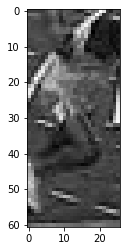

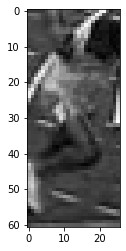

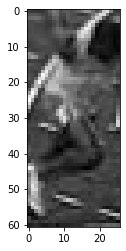

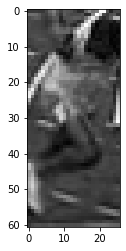

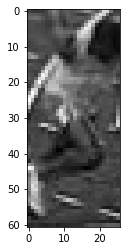

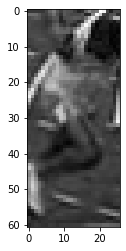

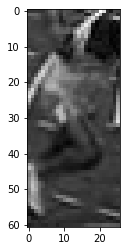

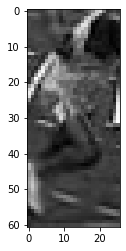

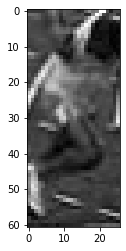

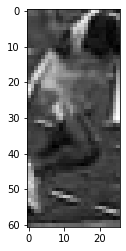

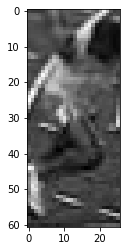

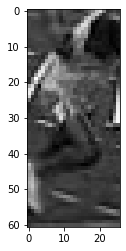

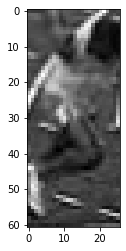

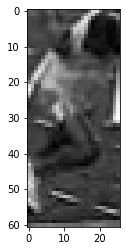

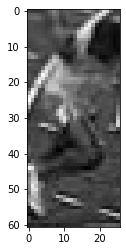

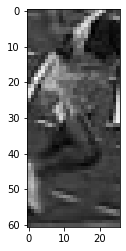

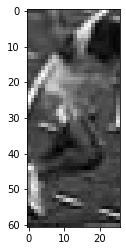

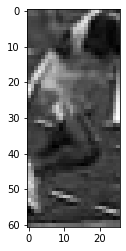

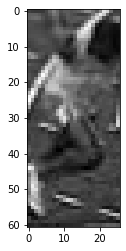

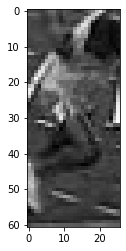

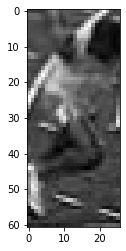

array([-2.20428855e-03, -2.20428855e-03,  1.08198689e-02,  1.08198689e-02,
       -3.37618864e+02, -1.66618864e+02])

In [11]:
lucas_kanade_matching(img_path, template_path, bbox, epsilon)